In [1]:
from anonypy.anonypy import anonypy
import pandas as pd
import numpy as np

data_file_path = 'full_output.csv' 
df = pd.read_csv(data_file_path)

categorical = set(("test","Outcome"))  

D:\software\Anaconda\anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\software\Anaconda\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
df

,test,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72.0,35,169.5,33.6,0.627,50,1
1,1,1,85,66.0,29,102.5,26.6,0.351,31,0
2,1,8,183,64.0,32,169.5,23.3,0.672,32,1
3,1,1,89,66.0,23,94.0,28.1,0.167,21,0
4,1,5,137,40.0,35,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...,...
763,1,10,101,76.0,48,180.0,32.9,0.171,63,0
764,1,2,122,70.0,27,102.5,36.8,0.340,27,0
765,1,5,121,72.0,23,112.0,26.2,0.245,30,0
766,1,1,126,60.0,32,169.5,30.1,0.349,47,1


In [3]:
for name in categorical:
    df[name] = df[name].astype("category")

feature_columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
sensitive_column = "Outcome"

In [4]:
def k_anonymize_df(k, df, feature_columns, sensitive_column):
    p = anonypy.Preserver(df, feature_columns, sensitive_column)
    rows = p.anonymize_k_anonymity(k=4)
    dfn = pd.DataFrame(rows)
    return dfn

In [5]:
def wrap_dfn(dfn):
    new_dfn = pd.DataFrame()
    for _, row in dfn.iterrows():
        # 根据count列的值复制该行count次
        new_rows = pd.DataFrame([row.values] * row['count'], columns=dfn.columns)
        # 将新行添加到新的DataFrame中
        new_dfn = pd.concat([new_dfn, new_rows], ignore_index=True) 
        # 将新行的count值设置为1
        new_dfn.loc[new_dfn.shape[0]-row['count']:, 'count'] = 1
    new_dfn = new_dfn.drop('count', axis=1)
    new_dfn.to_csv('new_dfn.csv', index=False)
    return new_dfn

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale, StandardScaler

In [7]:
def preprocess(new_dfn):
    # 类别型特征列表
    cat_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    # 对类别型特征进行one-hot编码
    data_encoded = pd.get_dummies(new_dfn, columns=cat_features)
    # 分离特征和标签
    X = data_encoded.drop('Outcome', axis=1)
    y = data_encoded['Outcome']
    # 对数值型特征进行归一化处理
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    # 合并归一化后的特征和标签
    preprocessed_data = pd.concat([X_scaled, y], axis=1)
    preprocessed_data.to_csv('preprocessed_data.csv', index=False)
    return X, y

In [8]:
def split_dataset(X, y):
    X_train, X_test, y_train , y_test = train_test_split(X,y, test_size=0.2, random_state=0)
    scaler =StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [9]:
def get_data(k):
    dfn = k_anonymize_df(k, df, feature_columns, sensitive_column)
    new_dfn = wrap_dfn(dfn)
    X, y = preprocess(new_dfn)
    X_train, X_test, y_train, y_test = split_dataset(X, y)
    return X_train, X_test, y_train.values, y_test.values

In [10]:
X_train, X_test, y_train, y_test = get_data(2)

E:\jupyter\eps\anonypy\anonypy\anonypy.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.loc[partition].groupby(sensitive_column).agg({sensitive_column: "count"})


In [11]:
X_train.shape, y_train.shape

((614, 1003), (614,))

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
def create_and_compile_model():
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    return model

In [14]:
def run_experiment_with_k(k):
    X_train, X_test, y_train, y_test = get_data(k)
    model = create_and_compile_model()
    r = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    hist = r.history
    return hist['val_accuracy']

In [15]:
from tqdm.notebook import trange

In [16]:
histories = []
for k in trange(2, 25):
    hist = run_experiment_with_k(k)
    histories.append(hist)

  0%|          | 0/23 [00:00<?, ?it/s]

E:\jupyter\eps\anonypy\anonypy\anonypy.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.loc[partition].groupby(sensitive_column).agg({sensitive_column: "count"})



E:\jupyter\eps\anonypy\anonypy\anonypy.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.loc[partition].groupby(sensitive_column).agg({sensitive_column: "count"})
E:\jupyter\eps\anonypy\anonypy\anonypy.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.loc[partition].groupby(sensitive_column).agg({sensitive_column: "count"})
E:\jupyter\eps\anonypy\anonypy\anonypy.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warn

In [20]:
max_dicovery = [max(h) for h in histories]

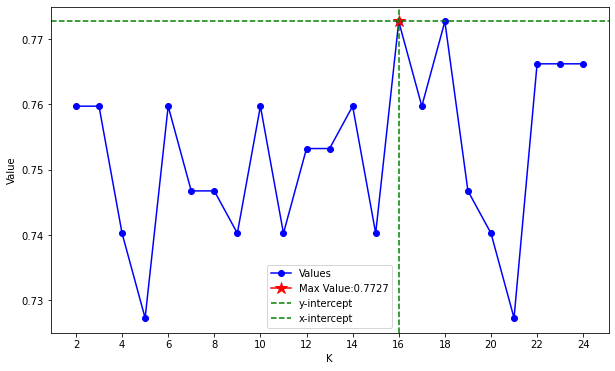

In [26]:
import matplotlib.pyplot as plt

# Sample list of float values
# Create a list of x-values (K values from 2 to 25)
x_values = list(range(2, 25))

# Find the maximum value and its index
max_value = max(max_dicovery)
max_index = max_dicovery.index(max_value)

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_values, max_dicovery, marker='o', linestyle='-', label='Values', color='b')
ax.plot(x_values[max_index], max_value, marker='*', markersize=12, color='r', label='Max Value:'+str(round(max_value, 4)))

# Plot x and y intercepts
ax.axhline(max_value, color='g', linestyle='--', label='y-intercept')
ax.axvline(max_index+2, color='g', linestyle='--', label='x-intercept')

ax.set_xlabel('K')
ax.set_ylabel('Value')
ax.set_xticks(range(2, 25, 2))  # Set x-ticks for every 2 values
ax.legend()
plt.show()